elapsed CPU time:  54.051635
Drag:  0.0804582722867


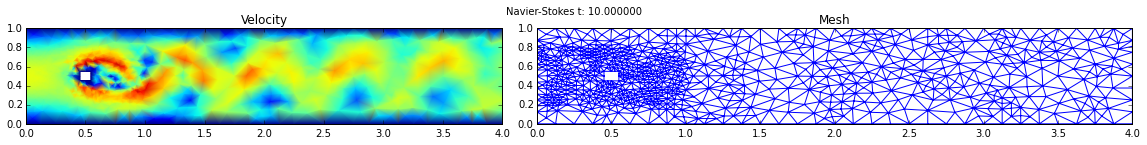

In [14]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)
       
       	# Plot norm of velocity
        plt.subplot(1, 2, 1);
        mplot_function(uEuclidnorm); 
        plt.title("Velocity")
        
        if t == 0.: 
           plt.colorbar(); 
           plt.axis(G)
        
        plt.subplot(1, 2, 2);
        
        if t == 0.:
           plt.triplot(mesh2triang(mesh)); 
           plt.title("Mesh") # Plot mesh
     	display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True); 

############## Important code starts here ##############

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution=20
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Rectangle(Point(0.5-0.05, 0.5-0.05), Point(0.5+0.05, 0.5+0.05)), mresolution)

nrefinement=2
for i in range(0, nrefinement): # Refine mesh
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim());
    for c in cells(mesh):
        p = c.midpoint()
        cell_markers[c] = (abs(p[0] - .5) < .5 and abs(p[1] - .5) < .3 and c.diameter() > .1) or c.diameter() > .2
    mesh = refine(mesh, cell_markers)

# FEM function spaces and functions
V = VectorFunctionSpace(mesh, "CG", 1); 
Q = FunctionSpace(mesh, "CG", 1);
W = V * Q; h = CellSize(mesh);
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX) 

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 0; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

print "elapsed CPU time: ", (time.clock() - timer0)  

psimarker = Expression("x[0]-0.5>-0.05-eps && x[0]-0.5<0.05+eps && x[1]-0.5>-0.05-eps && x[1]-0.5<0.05+eps ? 1. : 0.", eps=eps, domain=mesh, degree=3)

n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)

print "Drag: ", drag_force